# Named Entity Recognition using CRF model


```Named-entity recognition (NER) is a subtask of information extraction that seeks to locate and classify named entity mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.```

**CRF**

---



---



*   ```It is a type of Discriminative classifier.```<br>```They model the decision boundary between the different classes.```
*   ```To learn the decision boundary between the  classes, the classifier learns weights associated with each feature functions.```

*   score(&nbsp;l/s&nbsp;)=<sup> n </sup>∑<sub>i=1</sub>&nbsp;<sup>m</sup>∑<sub>j=1</sub>&nbsp;λ<sub>j</sub>&nbsp;f<sub>j</sub>(&nbsp;s&nbsp;,i&nbsp;,l<sub></sub>&nbsp;,l<sub>i-1</sub>&nbsp;)<br>
   ``` where n=length of the sentence and &nbsp;```λ<sub>j</sub> ```is the weight associated with feature functions``` f<sub>j</sub>. 

*   ```This scores are combined with transition scores``` T(y<sub>k-1</sub>&nbsp;,&nbsp;y<sub>k</sub>). <br>``` This represents the the likelihood transition of one label followed by another label.```

*   ```score is normalised over all the labels 
i.e. ```∑<sub>y∈Y</sub>score(&nbsp;l/s&nbsp;)&nbsp;+&nbsp;Transition scores(y<sub>k-1</sub>&nbsp;,&nbsp;y<sub>k</sub>)
*   ```summation is done over all the words in the sentences  and weights need to be optimised by maximal log likelihood method.```

*   ```Initial Weights are assigned randomly.```
*   ```Weights are optimized by gradient descent.```






In [ ]:
import pandas as pd
!pip install sklearn_crfsuite
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from collections import Counter
import matplotlib.pyplot as plt
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
path="Enter Path Here"
pd.options.display.max_rows = 4000

In [ ]:
#Reading the csv file
data = pd.read_csv(path+'ner_dataset.csv', encoding = "ISO-8859-1")
data.head(40)



*   ```Sentence # =id of sentence.```
*   ```Word represents word of sentence.```
*   ```POS represents part of speech of sentence.```
*   ```Tag represents tag of word.```<br>

**Fill NaN values**<br>


---



>*   ```There are lots of missing values in 'Sentence #' attribute.``` <br>```So we will use 'ffill' method which propagates last valid observation forward to next.```
>*   ```'ffill' stands for 'forward fill'```




In [0]:
data["Sentence #"]=data["Sentence #"].fillna(method='ffill')



```
To understand more about the DataFrame,
check below code and see how sentences can be 
reformed from the DataFrame.
```



In [0]:
sentences_list=data.groupby("Sentence #").apply(lambda a :a["Word"].tolist())
i=1
print("The {} sentence is ".format(i))
print(" ".join(sentences_list[i]))

The 1 sentence is 
Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .


In [0]:
data.describe()

,Unnamed: 0
count,1.048575e+06
mean,5.242870e+05
std,3.026977e+05
min,0.000000e+00
25%,2.621435e+05
50%,5.242870e+05
75%,7.864305e+05
max,1.048574e+06


**Verification Check For NULL Values**

---



In [0]:
data.isnull().sum()

Unnamed: 0    0
Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

**Class Distribution**

---



In [0]:
print("Total number of labels possible are ",len(data['Tag'].value_counts()))
data['Tag'].value_counts()

Total number of labels possible are  11


O        889420
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
I-gpe       198
Name: Tag, dtype: int64

```B- stands Beginning of Tag Phrase```<br>


```I-stands for inside of Tag Phrase.```<br>
```e.g. For entity "International Atomic Energy >Agency"```<br>
```Tagging goes like this```<br>
>```International - B-org``` <br>
>```Atomic - I-org```<br>
>```Energy - I-org``` <br>
>```Agency - I-org```<br>

```Entities abbreviations :-```<br>

>*   ```geo = Geographical Entity```
>*   ```org = Organization```
>*   ```per = Person```
>*   ```gpe = Geopolitical Entity```
>*   ```tim = Time indicator```









```
See what words have been tagged with which Tags.
```



In [0]:
from collections import Counter
tag_word_list=data.groupby("Tag").apply(lambda a :a["Word"].tolist())
for i in data["Tag"].unique():
  print(i,Counter(tag_word_list[i]).most_common(10))

O [('the', 52343), ('.', 47761), (',', 32476), ('in', 26199), ('of', 25127), ('to', 23095), ('a', 20481), ('and', 19228), ('The', 11038), ("'s", 10535)]
B-geo [('U.S.', 3169), ('Iraq', 1666), ('United', 1259), ('Iran', 1243), ('China', 908), ('Israel', 891), ('Afghanistan', 825), ('Pakistan', 733), ('Baghdad', 713), ('Russia', 554)]
B-gpe [('Iraqi', 1137), ('Palestinian', 988), ('Israeli', 987), ('Afghan', 814), ('British', 568), ('American', 539), ('Russian', 518), ('Pakistani', 466), ('Chinese', 453), ('Iranian', 380)]
B-per [('Mr.', 3085), ('President', 2411), ('Prime', 783), ('Minister', 197), ('Ms.', 176), ('John', 160), ('General', 139), ('Saddam', 119), ('Secretary', 98), ('Senator', 93)]
I-geo [('States', 1255), ('Korea', 477), ('Strip', 195), ('York', 185), ('of', 184), ('East', 181), ('Africa', 177), ('City', 144), ('Union', 120), ('Afghanistan', 114)]
B-org [('U.S.', 847), ('United', 728), ('U.N.', 547), ('Taleban', 542), ('NATO', 471), ('European', 448), ('al-Qaida', 397), 

**Histogram representation of Labels/Classes**

---



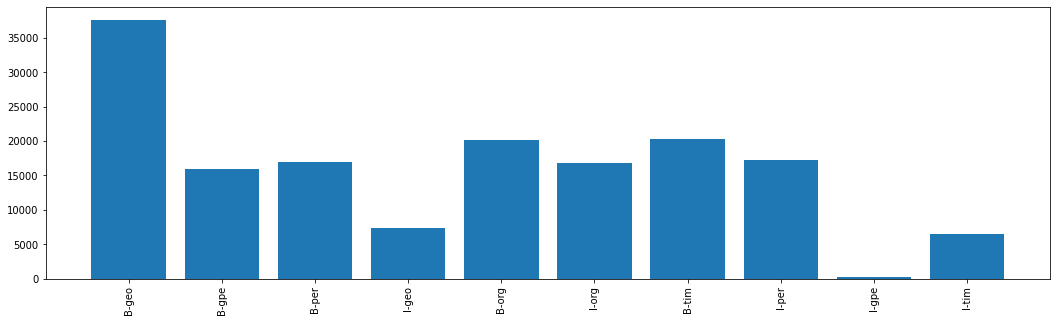

In [0]:
data.Tag.value_counts()
coun=Counter(" ".join(data[data["Tag"]!="O"]["Tag"]).split())
words= [x for x in coun]
values= [coun[x] for x in coun]
f, ax = plt.subplots(figsize=(18,5))
plt.bar(range(len(values)), values, align='center')
plt.xticks(range(len(words)), words, rotation='vertical')
plt.show()

**Sentence Class**

---



*   ```A Class to get sentences from the DataFrame with POS Tag and Labels.```

*   ```Each word will be in the form of tuple ,(Word,POS Tag,Labels).```



In [0]:
class sentence(object):
    def __init__(self, df):
        self.n_sent = 0
        self.df = df
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s=self.sentences[self.n_sent]
            self.n_sent +=1
            return s
        except:
            return None

In [0]:
getter = sentence(data)
print(getter.get_text())
# getter.grouped

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


```Getting all the sentences from the data in the above form```



In [0]:
sentences=getter.sentences

## Feature Preparation For CRF
>```CRF takes Features as inputs for each word.```<br>
>```BOS=Beginning Of Sentence.```<br>
>```EOS=End Of Sentence.```<br>


```Features with windows size of 1 step.```
>```Here, Features of each word is combined with the features of its one previous word and one next word.```


In [0]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

#converts each words of sentences into features based on their position in the sentence
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

#extract labels for all the word in the sentence
def sent2labels(sent):
    return [label for token, postag, label in sent]

```Features with windows size of 2 steps```
>```Here Features of each word is combined with the features of its two previous words and two next words.```<br>


>```Uncomment this to use Features with window size =2.```

In [0]:
# def word2features(sent, i):
#     word = sent[i][0]
#     postag = sent[i][1]
#     features = {
#         'bias': 1.0,
#         'word.lower()': word.lower(),
#         'word[-3:]': word[-3:],
#         'word[-2:]': word[-2:],
#         'word.isupper()': word.isupper(),
#         'word.istitle()': word.istitle(),
#         'word.isdigit()': word.isdigit(),
#         'postag': postag,
#         'postag[:2]': postag[:2],
#     }
#     if i > 0:
#         word1 = sent[i-1][0]
#         postag1 = sent[i-1][1]
#         features.update({
#             '-1:word.lower()': word1.lower(),
#             '-1:word.istitle()': word1.istitle(),
#             '-1:word.isupper()': word1.isupper(),
#             '-1:postag': postag1,
#             '-1:postag[:2]': postag1[:2],
#         })
#     else:
#         features['BOS'] = True
#     if i > 1:
#         word2 = sent[i-2][0]
#         postag2 = sent[i-2][1]
#         features.update({
#             '-2:word.lower()': word2.lower(),
#             '-2:word.istitle()': word2.istitle(),
#             '-2:word.isupper()': word2.isupper(),
#             '-2:postag': postag2,
#             '-2:postag[:2]': postag2[:2],
#         })
#     if i < len(sent)-1:
#         word1 = sent[i+1][0]
#         postag1 = sent[i+1][1]
#         features.update({
#             '+1:word.lower()': word1.lower(),
#             '+1:word.istitle()': word1.istitle(),
#             '+1:word.isupper()': word1.isupper(),
#             '+1:postag': postag1,
#             '+1:postag[:2]': postag1[:2],
#         })
#     else:
#         features['EOS'] = True
#     if i < len(sent)-2:
#         word2 = sent[i+2][0]
#         postag2 = sent[i+2][1]
#         features.update({
#             '+2:word.lower()': word2.lower(),
#             '+2:word.istitle()': word2.istitle(),
#             '+2:word.isupper()': word2.isupper(),
#             '+2:postag': postag2,
#             '+2:postag[:2]': postag2[:2],
#         })

#     return features

# #converts each words of sentences into features based on their position in the sentence
# def sent2features(sent):
#     return [word2features(sent, i) for i in range(len(sent))]

# #extract labels for all the word in the sentence
# def sent2labels(sent):
#     return [label for token, postag, label in sent]

**Convert Sentences to Features**

---








In [0]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

**Train Test Split** 

---



In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


```
Let us have a look at training features and target labels.
```



In [0]:
print("Sentence is \"{}\"".format(" ".join([x["word.lower()"] for x in X_train[262]])))
for x in range(len(X_train[262])):
  print("\nWord is \"",X_train[262][x]["word.lower()"],"\"\nFeatures",X_train[262][x],"\nlabel is ",y_train[262][x])

Sentence is "the washington post-abc news survey indicates that 68 percent of the 1,125 respondents disagree with president bush on iraq ."

Word is " the "
Features {'bias': 1.0, 'word.lower()': 'the', 'word[-3:]': 'The', 'word[-2:]': 'he', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'DT', 'postag[:2]': 'DT', 'BOS': True, '+1:word.lower()': 'washington', '+1:word.istitle()': True, '+1:word.isupper()': False, '+1:postag': 'NNP', '+1:postag[:2]': 'NN'} 
label is  O

Word is " washington "
Features {'bias': 1.0, 'word.lower()': 'washington', 'word[-3:]': 'ton', 'word[-2:]': 'on', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NNP', 'postag[:2]': 'NN', '-1:word.lower()': 'the', '-1:word.istitle()': True, '-1:word.isupper()': False, '-1:postag': 'DT', '-1:postag[:2]': 'DT', '+1:word.lower()': 'post-abc', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'NNP', '+1:postag[:2]': 'NN'} 
label is  

**CRF**

---



In [0]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.83,
         c2 = 0.04,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.83, c2=0.04, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

**HyperParameter Tuning**

---



In [0]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
labels = list(crf.classes_)
labels.remove('O')

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=4,
                        scoring=f1_scorer)
# rs = GridSearchCV(crf, params_space,
#                         cv=3)
rs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 27.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=False, averaging=None,
                                 c=None, c1=0.38, c2=0.05,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f899d23dcc0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f899d23db00>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,




```
RandomSearch Parameters
```



In [0]:
crf = rs.best_estimator_
_x = [s for s in rs.cv_results_["param_c1"]]
_y = [s for s in rs.cv_results_["param_c2"]]
_c = [s for s in rs.cv_results_["mean_test_score"]]
print("C1 values",_x)
print("C2 values",_y)
print("mean_test_score",_c)
print("best_params_",rs.best_params_)

C1 values [0.8708164040352444, 0.035933284376139796, 0.08735358204068532, 0.8319224476879056]
C2 values [0.05310179750020836, 0.07676187305579288, 0.041151338423833735, 0.03499586847169429]
mean_test_score [0.848838288591617, 0.8495100437057047, 0.8496994155201308, 0.8498575445523352]
best_params_ {'c1': 0.8319224476879056, 'c2': 0.03499586847169429}




```
Parameters Plotting for C1 , C2 and the scores.
```




Dark blue => 0.8488, dark red => 0.8499


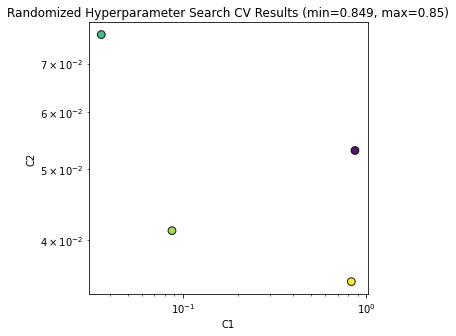

In [0]:
fig = plt.figure()
fig.set_size_inches(5, 5)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

**Training Analysis**<br><br>
>```Before making Predictions``` ,<br>```Let us see, what CRF has learnt during this training to understand more about Transition Scores and Feature Functions.```
<br>
```This can be done using module named "eli5".```

**Eli5**

---


<br>```Eli5 can be used to see weights and features matrix in Crf.```

In [0]:
!pip install eli5
import eli5
expl=eli5.explain_weights(crf,top=30)
df=eli5.format_as_dataframes(expl)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


**Obersvations**

*   ```Transition from "O" label to "I-prefix" are not observed.Hence, the transition score is approximately zero.```
*   ```Transition from "B-prefix" of a label to itself. Hence, the transition score is approximately zero.```
*   ```Transition from "B-prefix" of one label to "I-prefix" of another label is not observed. Hence,the transition score is approximatly zero.```
*   ```Transition from "I-art" to other labels are present .```<br>
>> ```But Transition from "I-art" to "O" label is never observed. Hence,the transition score is negative.```<br>
>> ```Also, Transition from "I-art" to "B-tim" label is never observed. Hence,the transition score is negative.```

In [0]:
df["transition_features"][:100]

,from,to,coef
0,O,O,3.838435
1,O,B-geo,2.350350
2,O,I-geo,0.000000
3,O,B-gpe,1.298688
4,O,I-gpe,0.000000
5,O,B-org,2.028379
6,O,I-org,0.000000
7,O,B-per,4.506450
8,O,I-per,0.000000
9,O,B-tim,2.941179


In [0]:
df["targets"][:100]

,target,feature,weight
0,O,word.lower():month,8.231271
1,O,word.lower():last,7.658862
2,O,word[-2:]:N1,7.398309
3,O,word[-3:]:And,6.143634
4,O,word.lower():columbia,6.071389
5,O,word.lower():hurricane,5.706381
6,O,word.lower():chief,5.674132
7,O,word.lower():week,5.384864
8,O,word.lower():chairman,5.377207
9,O,word.lower():this,5.287799



*   ```These are the weights associated with each features for each of the target class.```<br>
*   ```These weights are learnt by CRF model during its training with given features for each class.```
*   ```The weights combined with transition scores are used to predict target class for the test data.```

```This makes it easy to understand the CRF model.```



**Prediction**

---



In [0]:
#Predicting on the test set.
y_pred = crf.predict(X_test)
# crf.transition_features_
# crf.state_features_


**Evaluating the model performance**

<br>```We will use precision, recall and f1-score metrics to evaluate the performance of the model since the accuracy is not a good metric for this dataset because we have an unequal number of data points in each class.```



In [0]:
report = flat_classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       B-geo       0.86      0.90      0.88     11406
       B-gpe       0.96      0.94      0.95      4806
       B-org       0.80      0.73      0.76      6074
       B-per       0.84      0.82      0.83      4970
       B-tim       0.93      0.87      0.90      6080
       I-geo       0.83      0.78      0.80      2220
       I-gpe       0.82      0.55      0.66        58
       I-org       0.78      0.80      0.79      5042
       I-per       0.84      0.90      0.87      5054
       I-tim       0.84      0.75      0.79      1987
           O       0.99      0.99      0.99    266662

    accuracy                           0.97    314359
   macro avg       0.86      0.82      0.84    314359
weighted avg       0.97      0.97      0.97    314359



*   Precision of 1 means number of False Positive = 0.
*   Recall of 1 means number of False Negative = 0.
*   "I-gpe" has precision = 0.82, means when the model predicts "I-gpe".Hence, it is most likely to be "I-gpe" tag.
<br>This inference can also be used to predict "B-gpe". 
*   But "I-gpe" has recall = 0.55, means when the model predicts any tag other than "I-gpe" , it still can be the "I-gpe" tag.

*   The "support" indicates number of obervations correspondingly which is very less for "I-gpe".<br>Hence, accuracy is very less for this Tag.




```
These are the results when Feature Window size was increased from 1 to 2.
```



In [0]:
report = flat_classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       B-geo       0.87      0.91      0.89     11346
       B-gpe       0.96      0.94      0.95      4718
       B-org       0.81      0.74      0.77      6092
       B-per       0.84      0.83      0.83      5095
       B-tim       0.93      0.88      0.91      6038
       I-geo       0.82      0.81      0.81      2142
       I-gpe       0.86      0.45      0.59        67
       I-org       0.83      0.79      0.81      5161
       I-per       0.85      0.90      0.87      5185
       I-tim       0.84      0.74      0.79      1917
           O       0.99      0.99      0.99    267263

    accuracy                           0.97    315024
   macro avg       0.87      0.82      0.84    315024
weighted avg       0.97      0.97      0.97    315024




*   "I-gpe" has precision = 0.86, means when the model predicts "I-gpe".Hence, it is more likely to be the "I-gpe" tag than when predicted by the above model.
<br>This inference can also be used to predict "B-gpe". 
*   But "I-gpe" has recall = .45 is also reduced indicating False Negative are increased.<br>It means when the model predicts any tag other than "I-gpe" , it now has more chances to be  the "I-gpe" tag as compared to when predicted by previous model.



---



---
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```END!```

---



---

